##  **Imports** & **Setup**

In [2]:
import torch
import joblib
import numpy as np
import torch.nn as nn
import lightgbm as lgb
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler,OrdinalEncoder

scaler_test =MinMaxScaler()
scaler = MinMaxScaler()
ordinal_encoder = OrdinalEncoder()

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [4]:
!unzip /content/zippy.zip


Archive:  /content/zippy.zip
  inflating: zippy/inner.csv         
  inflating: zippy/outer.csv         


In [5]:
device

device(type='cuda', index=0)

## **Basic/General Data Cleaning**

In [6]:
inner = pd.read_csv('/content/zippy/inner.csv', low_memory=False)
outer = pd.read_csv('/content/zippy/outer.csv', low_memory=False)

In [7]:
inner.shape

(405172, 43)

In [8]:
def preprocess_time(df):
    for i in ['timestamp', 'sunrise', 'sunset', 'dt']:
        df[i] = pd.to_datetime(df[i])
        df[(i+'_day')] = df[i].dt.day
        df[(i+'_month')] = df[i].dt.month
        df[(i+'_hour')] = df[i].dt.hour
        df[(i+'_minute')] = df[i].dt.minute

        if i == 'timestamp':
            continue
        else:
            df.drop(i, axis=1, inplace=True)

    return df

In [9]:
def preprocess(dataframe):

    dataframe = dataframe.rename(columns={'humidity': 'humidity%'})
    column_to_dropna = 'value'
    dataframe = dataframe.dropna(subset=[column_to_dropna])
    dataframe = dataframe.pivot(
        index=dataframe.columns[:-2], columns='measurement', values='value').reset_index()

    dataframe['Compiled_Loaction'] = dataframe['text'].fillna('') + ' ' + dataframe['place'].fillna('') + ' ' + dataframe['region'].fillna('') + ' ' + dataframe['locality'].fillna('') + ' ' + dataframe['neighborhood'].fillna('') + ' ' + dataframe['country'].fillna('')+ dataframe['place_name'].fillna('')
    columns_to_drop = ['text', 'place', 'region', 'locality', 'neighborhood', 'country','place_name','postcode','uvi','dew_point']
    dataframe.drop(columns=columns_to_drop, inplace=True)
    dataframe['wind_gust'].fillna(dataframe['wind_gust'].mean(), inplace=True)
    dataframe['rain'].fillna(0, inplace=True)
    dataframe['snow'].fillna(0, inplace=True)
    dataframe['accuracy'].fillna(0, inplace=True)


    dataframe = preprocess_time(dataframe)

    dataframe = dataframe.sort_values(by='timestamp')

    dataframe.reset_index(drop=True, inplace=True)

    return dataframe

In [10]:
inner = preprocess(inner)
outer = preprocess(outer)

# **Predicting the Internal Temperature and Humidity**

## **Data Preprocessing**

In [11]:
inner.drop_duplicates(inplace=True)
outer.drop_duplicates(inplace=True)

inner.reset_index(inplace=True)
outer.reset_index(inplace=True)

In [12]:
length = len(outer)
outer['merger_col'] = range(length)

length = len(inner)
inner['merger_col'] = range(length)

In [13]:
merged_df = pd.merge(inner, outer, on=['merger_col', 'timestamp', 'pkId', 'fkLinkSerialId', 'temperature','humidity'], suffixes=['_inner', '_outer'])
merged_df.drop(['timestamp', 'merger_col'], axis=1, inplace=True)

In [14]:
simulated_trip_data_cut_out = merged_df.loc[(merged_df['fkLinkSerialId'] == '0XB827EB3B7400') &
                                     (merged_df['Compiled_Loaction_inner'] == '145 Road Sebringville CA-ON   ca4651 145 Road, Sebringville, Ontario N0K 1X0, Canada')].copy()

In [15]:
merged_df_encoded = merged_df.copy()

object_columns = merged_df_encoded.select_dtypes(include=['object']).columns

merged_df_encoded[object_columns] = merged_df_encoded[object_columns].astype(str)

merged_df_encoded[object_columns] = ordinal_encoder.fit_transform(merged_df_encoded[object_columns])

merged_df_encoded.dropna(inplace=True)

joblib.dump(ordinal_encoder, 'tools/ordinal_encoder.pkl')

['ordinal_encoder.pkl']

In [16]:
X = merged_df_encoded.drop(['temperature','humidity'],axis=1)
y = merged_df_encoded[['temperature','humidity']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=27)

X_train = scaler_test.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=X.columns)

X_test = pd.DataFrame(scaler_test.transform(X_test), columns=X_test.columns)

## **Modelling**

###  Features Selection

In [17]:
# Create LightGBM model
lgb_model = lgb.LGBMRegressor()

# Create the MultiOutputRegressor with LightGBM as the base estimator
multioutput_model = MultiOutputRegressor(lgb_model)

# Fit the multi-output model on the training data
multioutput_model.fit(X_train, y_train)

# Predict on the test data
y_pred = multioutput_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)

Mean Squared Error: 24.371634574277078


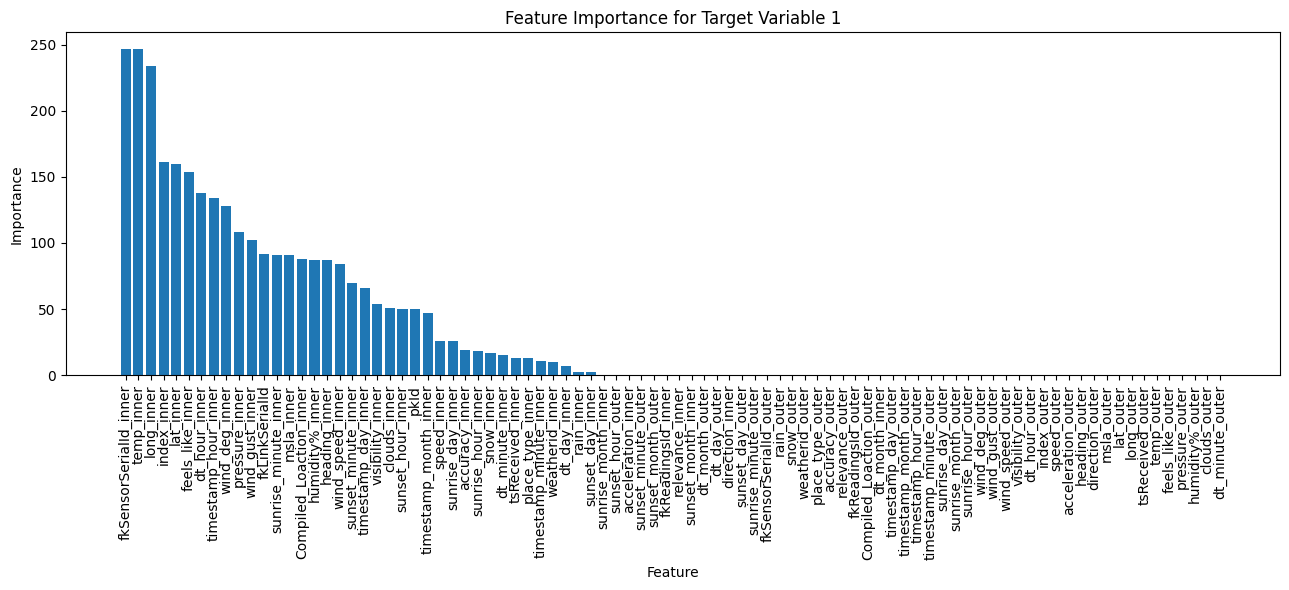

In [18]:
feature_importances= multioutput_model.estimators_[0].feature_importances_

# Get the feature names
feature_names = X.columns

# Sort feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]

# Plot the feature importances for target variable 1
plt.figure(figsize=(13, 6))
plt.bar(range(len(feature_importances)),
        feature_importances[sorted_idx], align='center')
plt.xticks(range(len(feature_importances)),
           feature_names[sorted_idx], rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance for Target Variable 1')
plt.tight_layout()
plt.show()

In [19]:
# Set the threshold for feature importance
threshold = 50

# Filter feature names based on feature importance
selected_columns= feature_names[sorted_idx][feature_importances[sorted_idx] > threshold].tolist()

In [21]:
selected_columns.remove('index_inner')

### Main Model

In [23]:
X = merged_df_encoded[selected_columns]
y = merged_df_encoded[['humidity','temperature']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27)


X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

joblib.dump(scaler, 'tools/scaler.pkl')

['scaler.pkl']

In [24]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

class TempHumidModel(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(TempHumidModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Set the model parameters
input_size = X_train_tensor.shape[1]
hidden_dim = 1024

# Create an instance of the model
model = TempHumidModel(input_size, hidden_dim).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
num_epochs = 300
batch_size =  256
num_batches = len(X_train_tensor) // batch_size
print(num_batches)
for epoch in range(num_epochs):
    for batch in range(num_batches):
        start = batch * batch_size
        end = (batch + 1) * batch_size
        inputs = X_train_tensor[start:end]
        targets = y_train_tensor[start:end]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.inference_mode():
        model.eval()
        y_pred_tensor = model(X_test_tensor)
        mse = mean_squared_error(y_test.values, y_pred_tensor.detach().cpu().numpy())

    # Print the loss after every epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Test Error:{mse}")




618
Epoch 1/300, Loss: 113.53794860839844, Test Error:112.48191097647653
Epoch 2/300, Loss: 89.01541900634766, Test Error:89.34564983713088
Epoch 3/300, Loss: 77.15263366699219, Test Error:78.78684918776317
Epoch 4/300, Loss: 68.83894348144531, Test Error:72.75125253788264
Epoch 5/300, Loss: 62.8130989074707, Test Error:70.43727764531312
Epoch 6/300, Loss: 59.989376068115234, Test Error:64.98208862951554
Epoch 7/300, Loss: 56.78703308105469, Test Error:59.57106171107671
Epoch 8/300, Loss: 53.758277893066406, Test Error:55.03941487111764
Epoch 9/300, Loss: 50.888832092285156, Test Error:51.680193418847246
Epoch 10/300, Loss: 48.457984924316406, Test Error:49.36357536304166
Epoch 11/300, Loss: 46.72575759887695, Test Error:47.719357882898784
Epoch 12/300, Loss: 45.35712432861328, Test Error:46.39939980051247
Epoch 13/300, Loss: 44.513771057128906, Test Error:45.18705847868631
Epoch 14/300, Loss: 43.847660064697266, Test Error:44.140211178349574
Epoch 15/300, Loss: 43.14395523071289, Test

In [25]:
y_test.values[:15],y_pred_tensor[:15]

(array([[99.99, 21.65],
        [98.41, 10.31],
        [69.73, 31.21],
        [38.13, 19.44],
        [48.26, 23.49],
        [52.92, 18.54],
        [99.99, 10.75],
        [79.41, 16.67],
        [99.99, -1.1 ],
        [97.2 , 12.37],
        [62.12, 14.87],
        [64.14, 23.23],
        [85.18, 29.08],
        [50.75, 30.06],
        [99.99, -1.  ]]),
 tensor([[ 97.3158,  19.8985],
         [ 96.7696,  10.9546],
         [ 69.9864,  30.9278],
         [ 41.5594,  19.5625],
         [ 51.0357,  22.2530],
         [ 56.6948,  18.2096],
         [100.4640,   6.8031],
         [ 76.5531,  16.5261],
         [100.5058,  -3.0425],
         [ 95.6898,  11.3663],
         [ 63.3577,  14.5254],
         [ 66.3513,  23.1026],
         [ 86.5543,  26.7418],
         [ 49.8174,  30.8400],
         [ 99.3208,  -1.6305]], device='cuda:0'))

In [26]:

with torch.inference_mode():
    model.eval()
    y_pred_tensor = model(X_test_tensor)
    mse = mean_squared_error(y_test.values, y_pred_tensor.detach().cpu().numpy())
    print(mse)

7.97809092636474


In [28]:
torch.save(model.state_dict(), 'inner_temperature_humidity.pt')

## **Simulated Trip**

In [29]:
ordinal_encoder = joblib.load('tools/ordinal_encoder.pkl')
scaler = joblib.load('tools/scaler.pkl')

In [30]:
simulated_trip_data_cut_out_e = simulated_trip_data_cut_out.copy()
object_columns = simulated_trip_data_cut_out_e.select_dtypes(include=['object']).columns

#object_columns = [column for column in object_columns if column != column_to_remove]
simulated_trip_data_cut_out_e[object_columns] = simulated_trip_data_cut_out_e[object_columns].astype(str)

# Apply the ordinal encoder on new data
simulated_trip_data_cut_out_e[object_columns] = ordinal_encoder.transform(simulated_trip_data_cut_out_e[object_columns])

In [31]:
simulated_trip_data_cut_out_e.dropna(inplace=True)
simulated_trip_data_cut_out_e.reset_index(drop=True,inplace=True)
X = simulated_trip_data_cut_out_e[selected_columns]
y = simulated_trip_data_cut_out_e[['humidity','temperature']]


X_sim = scaler.transform(X)
X_sim = pd.DataFrame(X_sim, columns=X.columns)
X_sim_tensor = torch.tensor(X_sim.values, dtype=torch.float32).to(device)



In [32]:
with torch.inference_mode():
    model.eval()
    y_pred_tensor = model(X_sim_tensor)
    mse = mean_squared_error(y.values, y_pred_tensor.detach().cpu().numpy())
    print(f"Simulated mse is {mse}")

Simulated mse is 10.855182879955848


In [33]:
simulated_trip_data_cut_out_e[:-1]

measurement,index_inner,pkId,fkLinkSerialId,speed_inner,acceleration_inner,heading_inner,direction_inner,msla_inner,lat_inner,long_inner,...,sunrise_hour_outer,sunrise_minute_outer,sunset_day_outer,sunset_month_outer,sunset_hour_outer,sunset_minute_outer,dt_day_outer,dt_month_outer,dt_hour_outer,dt_minute_outer
0,179625,3501019,7.0,0,1,0,0.0,345,43.481602,-81.068581,...,7.0,0.0,4.0,4.0,19.0,53.0,4.0,4.0,13.0,48.0
1,179626,3501019,7.0,0,1,0,0.0,345,43.481602,-81.068581,...,7.0,0.0,4.0,4.0,19.0,53.0,4.0,4.0,13.0,48.0
2,179627,3501027,7.0,0,1,0,0.0,347,43.481503,-81.068550,...,7.0,0.0,4.0,4.0,19.0,53.0,4.0,4.0,13.0,48.0
3,179628,3501027,7.0,0,1,0,0.0,347,43.481503,-81.068550,...,7.0,0.0,4.0,4.0,19.0,53.0,4.0,4.0,13.0,48.0
4,179629,3501035,7.0,1,1,0,0.0,354,43.481724,-81.068649,...,7.0,0.0,4.0,4.0,19.0,53.0,4.0,4.0,13.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1589,202580,3590636,7.0,0,1,0,0.0,349,43.481346,-81.068695,...,6.0,32.0,21.0,4.0,20.0,13.0,21.0,4.0,15.0,35.0
1590,202581,3590705,7.0,0,1,0,0.0,362,43.481396,-81.068588,...,6.0,32.0,21.0,4.0,20.0,13.0,21.0,4.0,15.0,56.0
1591,202582,3590705,7.0,0,1,0,0.0,362,43.481396,-81.068588,...,6.0,32.0,21.0,4.0,20.0,13.0,21.0,4.0,15.0,56.0
1592,202583,3590705,7.0,0,1,0,0.0,362,43.481396,-81.068588,...,6.0,32.0,21.0,4.0,20.0,13.0,21.0,4.0,15.0,56.0


In [34]:
# Create a function to simulate the trip
def simulate_trip(dataframe):
    with torch.inference_mode():
        for index, row in dataframe.iterrows():
            # Extract the selected features from the current row
            features = row[dataframe.columns]

            # Prepare the features for prediction (e.g., reshape or scale if necessary)
            features = features.values.reshape(1, -1)

            features = torch.tensor(features, dtype=torch.float32).to(device)

            # Make a prediction using the model
            model.eval()
            prediction = model(features)

            prediction = prediction.detach().cpu().numpy()

            sum_predictions = prediction[0][0] # First element of the first output variable
            additional_predictions = prediction[0][1]  # Second element of the first output variable



            print(f"Prediction for row {index}:| humidity:| true:{y['humidity'][index]} predicted: {sum_predictions}, temperature: true:{y['temperature'][index]} predicted:{additional_predictions}")

        # Simulate the passage of time or any other relevant actions between rows if needed

# Call the simulate_trip function with your trip data
simulate_trip(X_sim)


Prediction for row 0:| humidity:| true:99.99 predicted: 99.85214233398438, temperature: true:16.52 predicted:13.87246036529541
Prediction for row 1:| humidity:| true:99.99 predicted: 99.26277923583984, temperature: true:19.23 predicted:17.7764892578125
Prediction for row 2:| humidity:| true:99.99 predicted: 99.87342071533203, temperature: true:15.0 predicted:13.838364601135254
Prediction for row 3:| humidity:| true:99.99 predicted: 99.3286361694336, temperature: true:19.27 predicted:17.758493423461914
Prediction for row 4:| humidity:| true:99.99 predicted: 99.9318618774414, temperature: true:15.0 predicted:13.710050582885742
Prediction for row 5:| humidity:| true:99.99 predicted: 99.1416244506836, temperature: true:17.68 predicted:14.385688781738281
Prediction for row 6:| humidity:| true:99.99 predicted: 99.23381042480469, temperature: true:16.42 predicted:13.971068382263184
Prediction for row 7:| humidity:| true:99.99 predicted: 98.65029907226562, temperature: true:17.64 predicted:14.